# Plot iqTree divergence trees with baltic

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
bt = imp.load_source('baltic', '../baltic/baltic-iqtree.py')


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import numpy as np
import pandas as pd
from scipy.special import binom

import rpy2
%load_ext rpy2.ipython

In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [3]:
def load_tree(tree_path):
    tree = bt.loadNewick(tree_path)
    return(tree)

In [4]:
# read in metadata dictionary
def generate_metadata_dictionary(metadata_path):
    metadata = {}

    with open(metadata_path, "r") as infile: 
        for line in infile: 
            if "MuV_genotype" not in line:
                strain = line.split("\t")[0].replace("?","_")  #iqtree will do this replacement
                division = line.split("\t")[6]
                date = line.split("\t")[3]
                if date == "?":
                    date1 = "XXXX-XX-XX"
                else:
                    date1 = date

                metadata[strain] = {"division":division, "date":date1}
    metadata["KM597072.1"] = {"division":"reference", "date":"2013-XX-XX"}
    return(metadata)

In [5]:
def plot_full_genome_divergence_tree(tree,metadata,colors,division_order,output_name):
    fig,ax = plt.subplots(figsize=(16,12),facecolor='w')

    divergence = [0,0.002,0.004,0.006,0.008,0.01,0.012]
    [ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in divergence]

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    branchWidth=1.75 ## default branch width


    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name

            c=colors[metadata[k.numName]['division'].lower().replace(" ","_")]
            if metadata[k.numName]['division'].lower() == "reference":
                s = 0
            else:
                s=30 ## tip size can be fixed

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            c="#696969"
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []


        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
        #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlim(0,0.012)
    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
    ax.set_yticklabels([])
    ax.set_xticks(divergence)

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.04, 0.1], loc=3,prop={'size': 12}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(output_name)

    plt.show()

In [6]:
def plot_SH_divergence_tree(tree,metadata,colors,division_order,output_name):
    fig,ax = plt.subplots(figsize=(16,12),facecolor='w')

    divergence = [0,0.01,0.02,0.03,0.04]
    [ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in divergence]

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    branchWidth=1.75 ## default branch width


    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name

            c=colors[metadata[k.numName]['division'].lower().replace(" ","_")]
            if metadata[k.numName]['division'].lower() == "reference":
                s = 0
            else:
                s=30 ## tip size can be fixed

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            c="#696969"
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []


        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
        #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xlim(0,0.04)
    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
    ax.set_yticklabels([])
    ax.set_xticks(divergence)

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.4, 0.1], loc=3,prop={'size': 12}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(output_name)

    plt.show()

In [7]:
def output_treefile_with_dates_in_name(tree_path,metadata):
    with open(tree_path, "r") as infile: 
        for line in infile: 
            for strain in metadata:
                new_strain = strain + "|" + str(metadata[strain]['date'])
                line = line.replace(strain, new_strain)
            with open(tree_path.replace(".nwk",".with-dates.nwk"), "w") as outfile: 
                outfile.write(line)

# Run 

In Figtree, I manually rooted the tree (midpoint) and ordered the nodes to be in descending order. Then, export as newick and check "export as displayed" or something like that. 

In [9]:
colors = {"british_columbia":"#3C285C",
          "california":"#471A93",
          "new_york":"#4928B4",
          "virginia":"#3F50CC",
          "georgia":"#273B82",
          "manitoba":"#597ED4",
          "arkansas":"#EEA160",
          "north_dakota":"#5098B9",
          "massachusetts":"#396867",
          "missouri":"#5CA7A4",
          "ontario":"#B2313D",
          "pennsylvania":"#588755",
          "texas":"#7CB878",
          "indiana":"#A4BE56",
          "michigan":"#FDBB29",
          "north_carolina":"#D4749B",
          "new_hampshire":"#FED479",
          "ohio":"#DAAC3D",
          "washington":"#2664A5",
          "illinois":"#EABACD",
          "kansas":"#D84F07",
          "new_jersey":"#DF4027",
          "montana":"#85252E",
          "wisconsin":"#59191E",
          "iowa":"#E77720",
          "alabama":"#D84F07",
          "louisiana":"#C82722",
         "reference":"white"}

In [10]:
division_order = ["british_columbia","california","new_york","georgia","virginia","manitoba","washington",
                  "north_dakota","massachusetts","missouri","pennsylvania","texas","indiana","ohio","michigan",
                  "new_hampshire","arkansas",'iowa',"kansas","new_jersey",
                  "louisiana","ontario","montana","wisconsin","north_carolina","illinois"]  

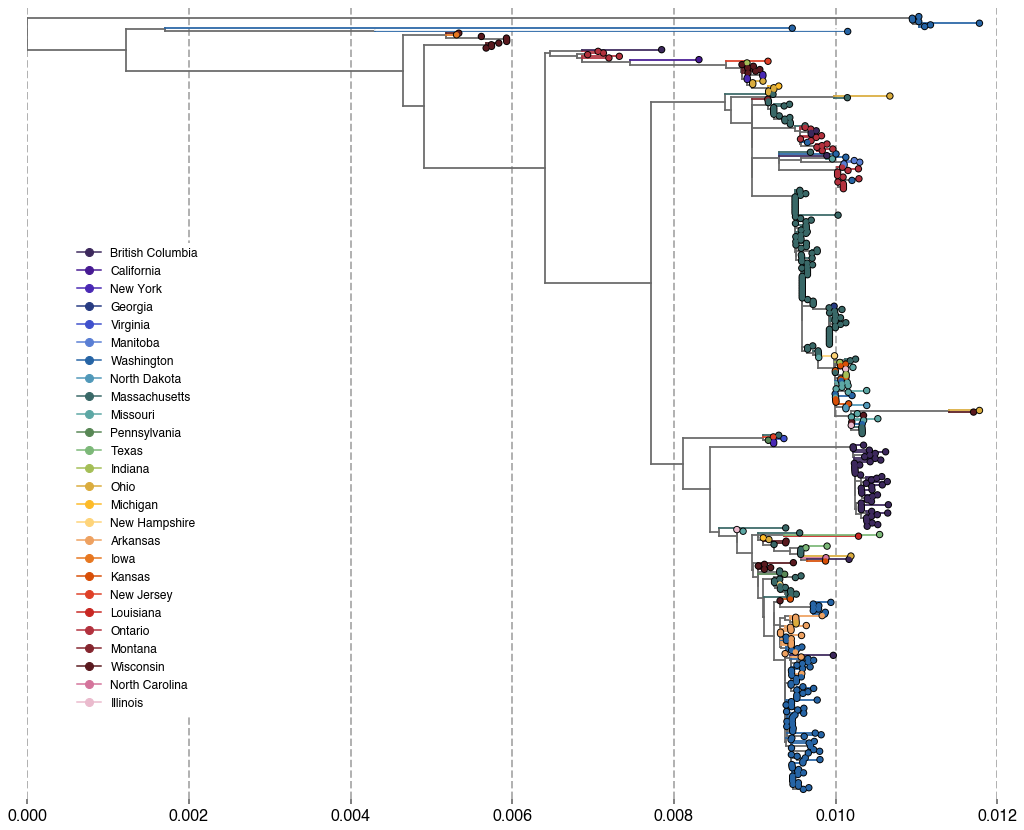

In [11]:
# run for the full genome tree first 
tree_path = "../divergence-tree-analyses/data/full-genome-tree-raw_na_rooted.nwk"
metadata_path = "../divergence-tree-analyses/data/full-North-America-metadata.tsv"
output_name = "../divergence-tree-analyses/data/full-genome-divergence-tree-2020-08-24.pdf"

tree = load_tree(tree_path)
metadata = generate_metadata_dictionary(metadata_path)
output_treefile_with_dates_in_name(tree_path,metadata)
plot_full_genome_divergence_tree(tree,metadata,colors,division_order,output_name)

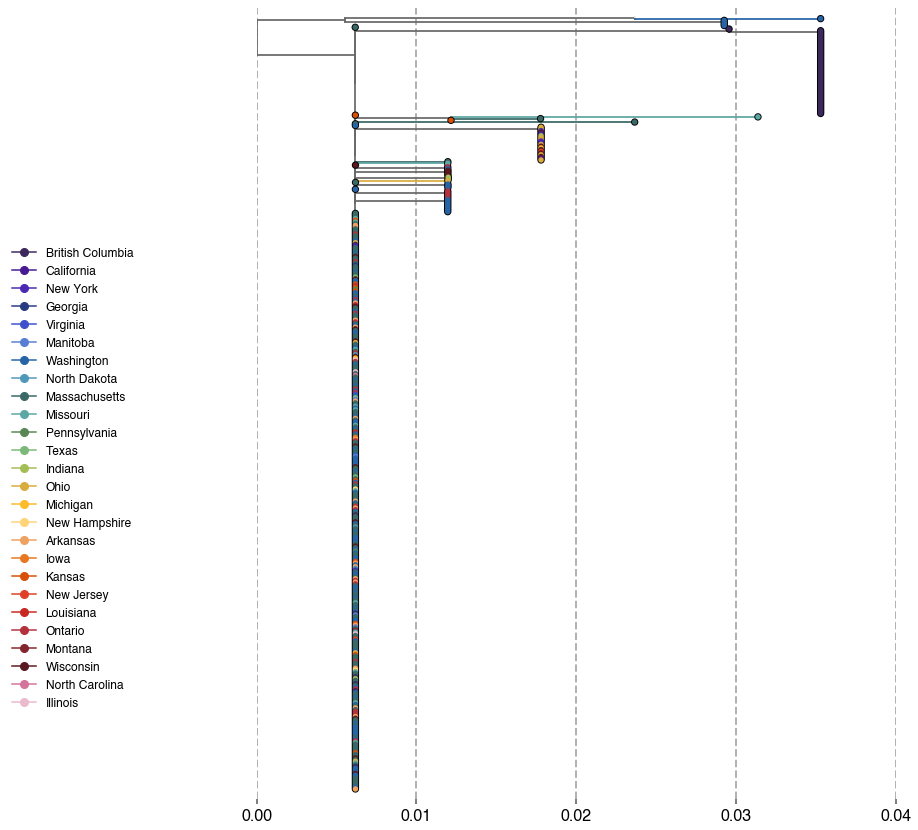

In [19]:
# run for SH only tree
tree_path = "../divergence-tree-analyses/data/SH-only-tree-raw_na_rooted.nwk"
metadata_path = "../divergence-tree-analyses/data/full-North-America-metadata.tsv"
output_name = "../divergence-tree-analyses/data/SH-divergence-tree-2020-08-24.pdf"

tree = load_tree(tree_path)
metadata = generate_metadata_dictionary(metadata_path)
output_treefile_with_dates_in_name(tree_path,metadata)
plot_SH_divergence_tree(tree,metadata,colors,division_order,output_name)

# Plot root to tip plot 

I ran `output_treefile_with_dates_in_name` on `/Users/lmoncla/src/mumps-no-dropped-na/results/tree-raw_na_rooted.nwk` and generated the output file `tree-raw_na_rooted.with-dates.nwk`. I read this file into TempEst version 1.5.1. and selected `heuristic residual mean squared` and `best-fitting root`. The correlation coefficient was 0.8637, and the R2 value was 0.7459. The slop was 3.749 x 10^-4. 

I exported the data to a text file in `/Users/lmoncla/src/mumps-no-dropped-na/results/tree-raw_na.with-dates.root-to-tip-2020-01-24.txt`. 

In [20]:
# read in output file 
tempest_file = "../divergence-tree-analyses/data/full-genome-tempest-root-to-tip-2020-01-24.txt"

In [21]:
df = pd.DataFrame.from_csv(tempest_file, sep="\t")
df.reset_index(inplace=True)
df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,tip,date,distance,residual
0,Washington.USA/2017391/14.17/G|2017-04-06,2017.260274,0.010272,-0.000446
1,Washington.USA/2017379/5.17/11/G|2017-02-08,2017.104110,0.010191,-0.000468
2,Washington.USA/2017386/11.17/4/G|2017-03-15,2017.200000,0.010194,-0.000501
3,Washington.USA/2017383/8.17/6/G|2017-02-22,2017.142466,0.010271,-0.000402
4,Washington.USA/2017396/19.17/4/G|2017-05-11,2017.356164,0.011022,0.000268


In [22]:
# add in color information as a column
splits = df['tip'].str.split("|", n=1, expand=True)
df['tip_name'] = splits[0]
df.head()

,tip,date,distance,residual,tip_name
0,Washington.USA/2017391/14.17/G|2017-04-06,2017.260274,0.010272,-0.000446,Washington.USA/2017391/14.17/G
1,Washington.USA/2017379/5.17/11/G|2017-02-08,2017.104110,0.010191,-0.000468,Washington.USA/2017379/5.17/11/G
2,Washington.USA/2017386/11.17/4/G|2017-03-15,2017.200000,0.010194,-0.000501,Washington.USA/2017386/11.17/4/G
3,Washington.USA/2017383/8.17/6/G|2017-02-22,2017.142466,0.010271,-0.000402,Washington.USA/2017383/8.17/6/G
4,Washington.USA/2017396/19.17/4/G|2017-05-11,2017.356164,0.011022,0.000268,Washington.USA/2017396/19.17/4/G


In [23]:
m = pd.DataFrame.from_dict(metadata, orient="index")
m.reset_index(inplace=True)
m.columns = ['tip_name','division','date']

# look up the color and add it as a column in the dataframe
m["colors_to_plot"] = m["division"].replace(colors)
m.head()

,tip_name,division,date,colors_to_plot
0,02-49,Japan,XXXX-XX-XX,Japan
1,31170132,Japan,2017-XX-XX,Japan
2,31170170,Japan,2017-XX-XX,Japan
3,31170186,Japan,2017-XX-XX,Japan
4,31170187,Japan,2017-XX-XX,Japan


In [57]:
# merge dataframes to plot 
combined = df.merge(m, how="left", on='tip_name')
combined['division'] = combined['division'].str.replace("_"," ")
combined['division'] = combined['division'].str.title()
combined = combined[combined['division'] != "Reference"]
combined.head()

,tip,date_x,distance,residual,tip_name,division,date_y,colors_to_plot
0,Washington.USA/2017391/14.17/G|2017-04-06,2017.260274,0.010272,-0.000446,Washington.USA/2017391/14.17/G,Washington,2017-04-06,Washington
1,Washington.USA/2017379/5.17/11/G|2017-02-08,2017.104110,0.010191,-0.000468,Washington.USA/2017379/5.17/11/G,Washington,2017-02-08,Washington
2,Washington.USA/2017386/11.17/4/G|2017-03-15,2017.200000,0.010194,-0.000501,Washington.USA/2017386/11.17/4/G,Washington,2017-03-15,Washington
3,Washington.USA/2017383/8.17/6/G|2017-02-22,2017.142466,0.010271,-0.000402,Washington.USA/2017383/8.17/6/G,Washington,2017-02-22,Washington
4,Washington.USA/2017396/19.17/4/G|2017-05-11,2017.356164,0.011022,0.000268,Washington.USA/2017396/19.17/4/G,Washington,2017-05-11,Washington


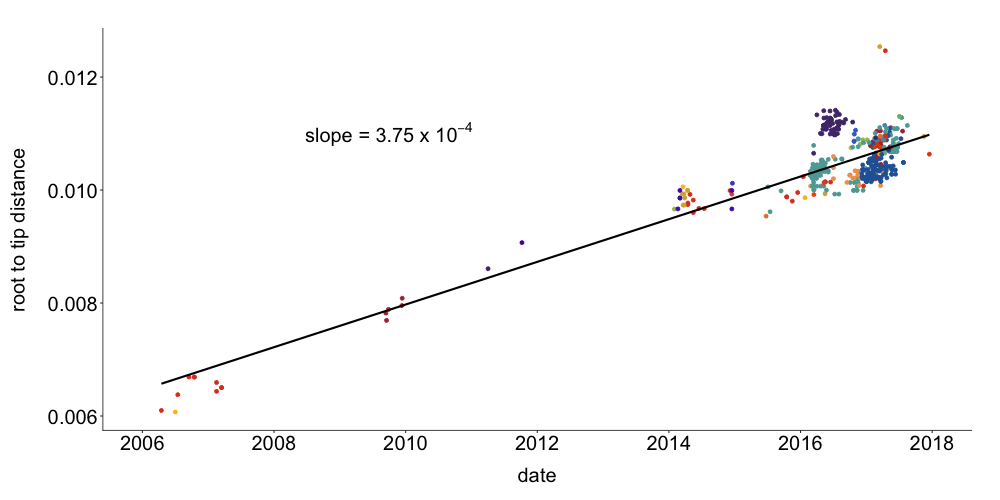

In [61]:
%%R -w 1000 -h 500 -u px -i combined  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

combined$divisionf = factor(combined$division, levels=c("California","New York","Massachusetts","Virginia","Georgia","Manitoba","Arkansas","North Dakota","Louisiana","Ontario","Texas","Indiana","Michigan","Montana","New Hampshire","Ohio","Washington","Illinois","Kansas","Pennsylvania","New Jersey","British Columbia", "Wisconsin","Iowa","Alabama","Missouri","North Carolina"))

p <- ggplot(data=combined, aes(x=date_x, y=distance, color=divisionf)) + 
    geom_point()+
    geom_smooth(method='lm',formula=y~x, color="black", se=FALSE)+
    #scale_color_manual(values = setNames(combined$colors_to_plot, levels(combined$division))) +
    scale_color_manual(values=c("California"="#511Ea8","New York"="#4928B4","Louisiana"="#B2313D","Virginia"="#3F50Cc","Georgia"="#3F5Ed0","Manitoba"="#416Cce","Arkansas"="#Eea160","North Dakota"="#5098B9","Massachusetts"="#5Ca7A4","Ontario"="#B2313D","Texas"="#7Cb878","Indiana"="#A4Be56","Michigan"="#Fdbb29","Montana"="#E35B0D","New Hampshire"="#Fdbb29","Ohio"="#Daac3D","Washington"="#2664A5","Illinois"="#E68234","Kansas"="#D84F07","Pennsylvania"="#E1512A","New Jersey"="#Df4027","British Columbia"="#50357A","Reference"="White","Wisconsin"="#DF4027", "Iowa"="#FDBB29","Alabama"="#D84F07","Missouri"="#5CA7A4","North Carolina"="#FDBB29"), guide=FALSE)+
    labs(x="date",y="root to tip distance")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(limits=c(2006,2018), breaks=seq(2006,2018,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, vjust=8))+
    theme(axis.title.x=element_text(size=20, vjust=-4))+
    theme(axis.text=element_text(size=20, colour="black"))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

# add in annotation with the regression stuff
p1 = p + annotate("text",x=2009.75,y=0.011,label=expression("slope = 3.75 x 10"^-4), size=7)
ggsave("2020-03-04-root-to-tip-no-legend.pdf", p1, width = 8, height = 4, path="/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/")
p1